In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from collections import Counter
from PIL import Image
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.model_selection import train_test_split
import hashlib
from pathlib import Path
import imagehash
from tensorflow.keras import backend as K

os.environ["TF_GPU_ALLOCATOR"] = 'cuda_malloc_async'
tf.compat.v1.disable_eager_execution()

# Define the directories for the dataset
data_dir = 'dataset/images'

# Define the image size and number of classes
img_size = (256, 256)

# Define the batch size and number of epochs
batch_size=128
seed = 42


def alpharemover(image):
    if image.mode != 'RGBA':
        return image
    canvas = Image.new('RGBA', image.size, (255,255,255,255))
    canvas.paste(image, mask=image)
    return canvas.convert('RGB')

def with_ztransform_preprocess(hashfunc, hash_size=8):
    def function(path):
        image = alpharemover(Image.open(path))
        image = image.convert("L").resize((hash_size, hash_size), Image.LANCZOS)
        data = image.getdata()
        quantiles = np.arange(100)
        quantiles_values = np.percentile(data, quantiles)
        zdata = (np.interp(data, quantiles_values, quantiles) / 100 * 255).astype(np.uint8)
        image.putdata(zdata)
        return hashfunc(image)
    return function

dhash_z_transformed = with_ztransform_preprocess(imagehash.dhash, hash_size = 8)

def remove_duplicate_images(data_dir):
    hash_dict = {}
    for class_dir in ['ham', 'spam']:
        class_path = Path(data_dir) / class_dir
        for image_path in class_path.iterdir():
            hash = dhash_z_transformed(image_path)
            if hash not in hash_dict:
                # This is a new unique image, so add it to our hash_dict
                hash_dict[hash] = image_path
            else:
                # This image is a duplicate of an existing one, so delete it
                print(f"Removing duplicate image: {image_path}")
                image_path.unlink()

    return hash_dict


# Call the function to remove duplicate images
hash_dict = remove_duplicate_images(data_dir)


2023-05-26 03:04:04.651048: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


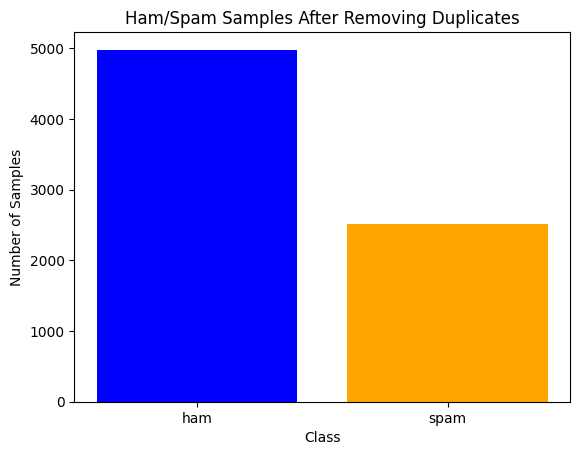

Found 4981 images belonging to 2 classes.
Found 1245 images belonging to 2 classes.


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:202: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn(
/tmp/ipykernel_7059/1775370901.py:92: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_clf = KerasClassifier(build_fn=build_model, callbacks=callbacks, verbose=0)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


2023-05-26 03:07:17.506125: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-26 03:07:17.510268: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-26 03:07:17.510383: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[CV] END batch_size=128, dropout_rate=0.2, epochs=50, learning_rate=0.01, optimizer=sgd; total time= 1.2min


2023-05-26 03:08:30.463777: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_2/bias/Assign' id:496 op device:{requested: '', assigned: ''} def:{{{node dense_2/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_2/bias, dense_2/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 03:09:51.918744: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_1/mul' id:592 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/dense_3_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session

[CV] END batch_size=128, dropout_rate=0.2, epochs=50, learning_rate=0.01, optimizer=sgd; total time= 1.4min


2023-05-26 03:09:53.167100: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_4/kernel/Assign' id:888 op device:{requested: '', assigned: ''} def:{{{node dense_4/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_4/kernel, dense_4/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 03:11:36.187462: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_2/mul' id:989 op device:{requested: '', assigned: ''} def:{{{node loss_2/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_2/mul/x, loss_2/dense_5_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running t

[CV] END batch_size=128, dropout_rate=0.2, epochs=50, learning_rate=0.01, optimizer=sgd; total time= 1.7min


2023-05-26 03:11:37.627440: W tensorflow/c/c_api.cc:300] Operation '{name:'training_6/RMSprop/dense_6/kernel/rms/Assign' id:1583 op device:{requested: '', assigned: ''} def:{{{node training_6/RMSprop/dense_6/kernel/rms/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_6/RMSprop/dense_6/kernel/rms, training_6/RMSprop/dense_6/kernel/rms/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 03:11:47.971174: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_3/mul' id:1386 op device:{requested: '', assigned: ''} def:{{{node loss_3/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_3/mul/x, loss_3/dense_7_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and wil

[CV] END batch_size=128, dropout_rate=0.2, epochs=50, learning_rate=0.01, optimizer=rmsprop; total time=  11.8s


2023-05-26 03:11:49.413324: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_8/bias/Assign' id:1915 op device:{requested: '', assigned: ''} def:{{{node dense_8/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_8/bias, dense_8/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 03:12:18.666297: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_4/mul' id:2011 op device:{requested: '', assigned: ''} def:{{{node loss_4/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_4/mul/x, loss_4/dense_9_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new sessi

[CV] END batch_size=128, dropout_rate=0.2, epochs=50, learning_rate=0.01, optimizer=rmsprop; total time=  30.8s


2023-05-26 03:12:20.202459: W tensorflow/c/c_api.cc:300] Operation '{name:'count_5/Assign' id:2589 op device:{requested: '', assigned: ''} def:{{{node count_5/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_5, count_5/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 03:12:34.202592: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_5/mul' id:2636 op device:{requested: '', assigned: ''} def:{{{node loss_5/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_5/mul/x, loss_5/dense_11_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


[CV] END batch_size=128, dropout_rate=0.2, epochs=50, learning_rate=0.01, optimizer=rmsprop; total time=  15.5s


2023-05-26 03:12:35.690770: W tensorflow/c/c_api.cc:300] Operation '{name:'training_12/Adam/conv2d_19/kernel/m/Assign' id:3434 op device:{requested: '', assigned: ''} def:{{{node training_12/Adam/conv2d_19/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_12/Adam/conv2d_19/kernel/m, training_12/Adam/conv2d_19/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 03:12:46.950694: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_6/mul' id:3261 op device:{requested: '', assigned: ''} def:{{{node loss_6/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_6/mul/x, loss_6/dense_13_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigg

[CV] END batch_size=128, dropout_rate=0.2, epochs=50, learning_rate=0.01, optimizer=adam; total time=  12.8s


2023-05-26 03:12:48.500842: W tensorflow/c/c_api.cc:300] Operation '{name:'training_14/Adam/decay/Assign' id:3967 op device:{requested: '', assigned: ''} def:{{{node training_14/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_14/Adam/decay, training_14/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 03:13:00.593973: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_7/mul' id:3816 op device:{requested: '', assigned: ''} def:{{{node loss_7/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_7/mul/x, loss_7/dense_15_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modi

[CV] END batch_size=128, dropout_rate=0.2, epochs=50, learning_rate=0.01, optimizer=adam; total time=  13.6s


2023-05-26 03:13:02.104027: W tensorflow/c/c_api.cc:300] Operation '{name:'training_16/Adam/beta_1/Assign' id:4512 op device:{requested: '', assigned: ''} def:{{{node training_16/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_16/Adam/beta_1, training_16/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 03:13:58.498449: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_8/mul' id:4371 op device:{requested: '', assigned: ''} def:{{{node loss_8/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_8/mul/x, loss_8/dense_17_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't 

[CV] END batch_size=128, dropout_rate=0.2, epochs=50, learning_rate=0.01, optimizer=adam; total time=  58.3s


2023-05-26 03:14:00.359710: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_18/kernel/Assign' id:4825 op device:{requested: '', assigned: ''} def:{{{node dense_18/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_18/kernel, dense_18/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 03:16:21.177927: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_9/mul' id:4926 op device:{requested: '', assigned: ''} def:{{{node loss_9/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_9/mul/x, loss_9/dense_19_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after ru

[CV] END batch_size=128, dropout_rate=0.2, epochs=50, learning_rate=0.001, optimizer=sgd; total time= 2.4min


2023-05-26 03:16:23.127525: W tensorflow/c/c_api.cc:300] Operation '{name:'conv2d_30/kernel/Assign' id:5145 op device:{requested: '', assigned: ''} def:{{{node conv2d_30/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_30/kernel, conv2d_30/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 03:18:44.355427: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_10/mul' id:5323 op device:{requested: '', assigned: ''} def:{{{node loss_10/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_10/mul/x, loss_10/dense_21_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes 

[CV] END batch_size=128, dropout_rate=0.2, epochs=50, learning_rate=0.001, optimizer=sgd; total time= 2.4min


2023-05-26 03:18:46.243288: W tensorflow/c/c_api.cc:300] Operation '{name:'conv2d_33/kernel/Assign' id:5542 op device:{requested: '', assigned: ''} def:{{{node conv2d_33/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_33/kernel, conv2d_33/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 03:21:07.660614: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_11/mul' id:5720 op device:{requested: '', assigned: ''} def:{{{node loss_11/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_11/mul/x, loss_11/dense_23_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes 

[CV] END batch_size=128, dropout_rate=0.2, epochs=50, learning_rate=0.001, optimizer=sgd; total time= 2.4min


2023-05-26 03:21:09.767516: W tensorflow/c/c_api.cc:300] Operation '{name:'training_24/RMSprop/dense_24/bias/rms/Assign' id:6319 op device:{requested: '', assigned: ''} def:{{{node training_24/RMSprop/dense_24/bias/rms/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_24/RMSprop/dense_24/bias/rms, training_24/RMSprop/dense_24/bias/rms/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 03:22:13.042362: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_12/mul' id:6117 op device:{requested: '', assigned: ''} def:{{{node loss_12/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_12/mul/x, loss_12/dense_25_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, an

[CV] END batch_size=128, dropout_rate=0.2, epochs=50, learning_rate=0.001, optimizer=rmsprop; total time= 1.1min


2023-05-26 03:22:15.058499: W tensorflow/c/c_api.cc:300] Operation '{name:'training_26/RMSprop/learning_rate/Assign' id:6888 op device:{requested: '', assigned: ''} def:{{{node training_26/RMSprop/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_26/RMSprop/learning_rate, training_26/RMSprop/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 03:23:10.328839: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_13/mul' id:6742 op device:{requested: '', assigned: ''} def:{{{node loss_13/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_13/mul/x, loss_13/dense_27_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will t

[CV] END batch_size=128, dropout_rate=0.2, epochs=50, learning_rate=0.001, optimizer=rmsprop; total time=  57.3s


2023-05-26 03:23:12.353869: W tensorflow/c/c_api.cc:300] Operation '{name:'training_28/RMSprop/decay/Assign' id:7508 op device:{requested: '', assigned: ''} def:{{{node training_28/RMSprop/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_28/RMSprop/decay, training_28/RMSprop/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 03:24:27.279989: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_14/mul' id:7367 op device:{requested: '', assigned: ''} def:{{{node loss_14/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_14/mul/x, loss_14/dense_29_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. E

[CV] END batch_size=128, dropout_rate=0.2, epochs=50, learning_rate=0.001, optimizer=rmsprop; total time= 1.3min


2023-05-26 03:24:29.324269: W tensorflow/c/c_api.cc:300] Operation '{name:'count_15/Assign' id:7945 op device:{requested: '', assigned: ''} def:{{{node count_15/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_15, count_15/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 03:25:43.570279: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_15/mul' id:7992 op device:{requested: '', assigned: ''} def:{{{node loss_15/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_15/mul/x, loss_15/dense_31_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


[CV] END batch_size=128, dropout_rate=0.2, epochs=50, learning_rate=0.001, optimizer=adam; total time= 1.3min


2023-05-26 03:25:45.640761: W tensorflow/c/c_api.cc:300] Operation '{name:'count_16/Assign' id:8500 op device:{requested: '', assigned: ''} def:{{{node count_16/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_16, count_16/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 03:26:51.241260: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_16/mul' id:8547 op device:{requested: '', assigned: ''} def:{{{node loss_16/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_16/mul/x, loss_16/dense_33_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


[CV] END batch_size=128, dropout_rate=0.2, epochs=50, learning_rate=0.001, optimizer=adam; total time= 1.1min


2023-05-26 03:26:53.281008: W tensorflow/c/c_api.cc:300] Operation '{name:'training_34/Adam/dense_35/kernel/m/Assign' id:9309 op device:{requested: '', assigned: ''} def:{{{node training_34/Adam/dense_35/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_34/Adam/dense_35/kernel/m, training_34/Adam/dense_35/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 03:27:50.366467: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_17/mul' id:9102 op device:{requested: '', assigned: ''} def:{{{node loss_17/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_17/mul/x, loss_17/dense_35_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigg

[CV] END batch_size=128, dropout_rate=0.2, epochs=50, learning_rate=0.001, optimizer=adam; total time=  59.2s


2023-05-26 03:27:52.036973: W tensorflow/c/c_api.cc:300] Operation '{name:'conv2d_55/bias/Assign' id:9509 op device:{requested: '', assigned: ''} def:{{{node conv2d_55/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_55/bias, conv2d_55/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Best: 0.8628853360811869 using {'batch_size': 128, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'optimizer': 'rmsprop'}


2023-05-26 03:29:29.887950: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_18/mul' id:9657 op device:{requested: '', assigned: ''} def:{{{node loss_18/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_18/mul/x, loss_18/dense_37_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


ValueError: could not convert string to float: 'spam'

In [2]:
# Plot graph of the ham/spam samples using bar chart before model build
ham_count = sum(1 for image_hash in hash_dict.values() if "ham" in str(image_hash))
spam_count = sum(1 for image_hash in hash_dict.values() if "spam" in str(image_hash))
plt.bar(["ham", "spam"], [ham_count, spam_count], color=["blue", "orange"])
plt.title("Ham/Spam Samples After Removing Duplicates")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

# Create an instance of the ImageDataGenerator class for data augmentation
data_augmentation = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # set validation split
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=lambda x: tf.image.resize_with_pad(x, target_height=img_size[0], target_width=img_size[1]))

# Use flow_from_directory method to load the training dataset
train_data_generator = data_augmentation.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    subset='training',
    seed=seed)  # set as training data

# Use flow_from_directory method to load the validation dataset
val_data_generator = data_augmentation.flow_from_directory(
    data_dir, 
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    seed=seed)  # set as validation data

# Create a function to build the model
from tensorflow.keras.optimizers import SGD, RMSprop, Adam

def build_model(optimizer='adam', learning_rate=0.001, dropout_rate=0.0):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    # Map optimizer name to optimizer class
    optimizers = {
        'sgd': tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate),
        'rmsprop': tf.keras.optimizers.legacy.RMSprop(learning_rate=learning_rate),
        'adam': tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    }

    # Get the correct optimizer
    opt = optimizers.get(optimizer)

    # Compile the model
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Specify parameters and distributions to sample from
param_grid = {
    'optimizer': ['sgd', 'rmsprop', 'adam'],
    'learning_rate': [0.01, 0.001],
    'dropout_rate': [0.2],
    'batch_size': [128],
    'epochs': [50]
}

class ClearMemory(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        K.clear_session()

# Specify callbacks
early_stopping = EarlyStopping(monitor='loss', patience=3)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.001)
callbacks = [early_stopping]

# Build the KerasClassifier
keras_clf = KerasClassifier(build_fn=build_model, callbacks=callbacks, verbose=0)

# Initialize lists to store the image data and labels
X = []
y = []

# Loop through each sub-directory in the main directory
for dir in os.listdir(data_dir):
    for filename in os.listdir(os.path.join(data_dir, dir)):
        # Load the image and resize it
        img = load_img(os.path.join(data_dir, dir, filename), target_size=img_size)
        # Convert the image to a NumPy array and add a batch dimension
        img = img_to_array(img)
        # Preprocess the image using the mobilenet_v2 preprocessing function
        img = preprocess_input(img)
        # Add the image to the list of images
        X.append(img)
        # Add the label to the list of labels
        y.append(dir)

# Convert the lists to NumPy arrays
X = np.array(X)
y = np.array(y)

# Perform a train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Perform the grid search
grid = GridSearchCV(estimator=keras_clf, param_grid=param_grid, cv=3, verbose=2)
grid_result = grid.fit(X_train, y_train) # Make sure to replace X_train and y_train with your training data

# Print results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

# Save the best model
best_model = grid_result.best_estimator_.model
best_model.save('best_model.h5')


In [5]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()

# Fit and transform the labels
y = le.fit_transform(y)

# Perform a train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Evaluate the best model on the test set
score = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

Test loss: 0.7277082320926506
Test accuracy: 0.8685790300369263


Means: 0.8323628703753153, Stdev: 0.01115665136051719 with: {'batch_size': 128, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.01, 'optimizer': 'sgd'}
Means: 0.6638866861661276, Stdev: 0.0016810760282104556 with: {'batch_size': 128, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.01, 'optimizer': 'rmsprop'}
Means: 0.6638866861661276, Stdev: 0.0016810760282104556 with: {'batch_size': 128, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.01, 'optimizer': 'adam'}
Means: 0.777148425579071, Stdev: 0.006815514776271807 with: {'batch_size': 128, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'optimizer': 'sgd'}
Means: 0.8628853360811869, Stdev: 0.005032933673026228 with: {'batch_size': 128, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'optimizer': 'rmsprop'}
Means: 0.8468726277351379, Stdev: 0.002470432201767715 with: {'batch_size': 128, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'optimizer': 'adam'}
Best: 0.8628853360811869 using {'

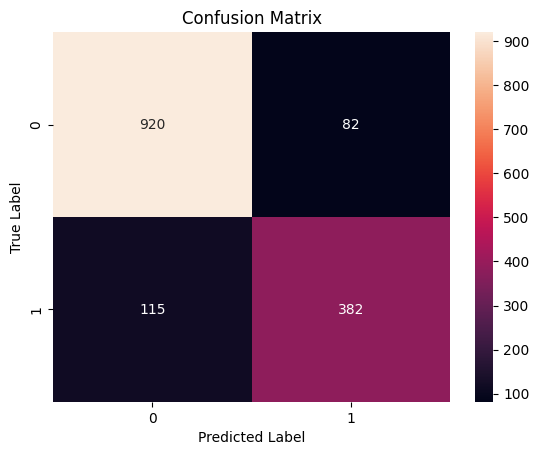

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      1002
           1       0.82      0.77      0.80       497

    accuracy                           0.87      1499
   macro avg       0.86      0.84      0.85      1499
weighted avg       0.87      0.87      0.87      1499



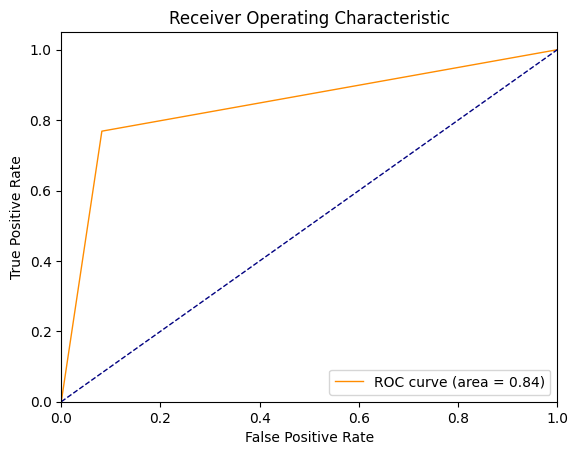

In [9]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

    
# Get the best model
best_model = grid_result.best_estimator_.model
best_model.save('best_model.h5')

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# Fit the encoder and transform y_train and y_test
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

# Print results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

# Evaluate the best model
score, acc = best_model.evaluate(X_test, y_test)

print('Test score:', score)
print('Test accuracy:', acc)

# Predictions
predictions = (best_model.predict(X_test) > 0.5).astype('int32')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Plotting Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification report
print(classification_report(y_test, predictions))

# ROC Curve and AUC for the test set
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [10]:
# Save the best model
best_model = grid_result.best_estimator_.model
best_model.save('best_model.h5')

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# Fit the encoder and transform y_train and y_test
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

# Evaluate the best model on the test set
score = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

Test loss: 0.7277082320926506
Test accuracy: 0.8685790300369263


2023-05-26 04:35:05.954471: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_55/kernel/Assign' id:14163 op device:{requested: '', assigned: ''} def:{{{node dense_55/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_55/kernel, dense_55/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-05-26 04:37:06.446820: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_55/Sigmoid' id:14174 op device:{requested: '', assigned: ''} def:{{{node dense_55/Sigmo

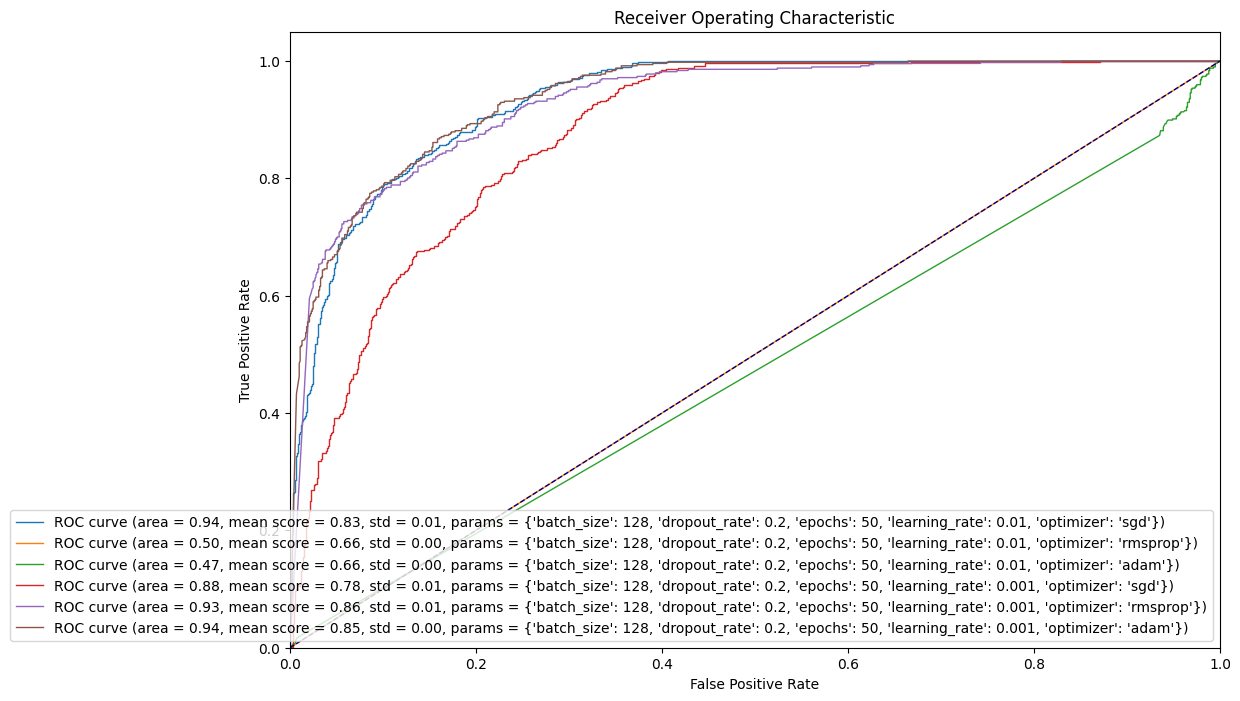

In [27]:
plt.figure(figsize=(12, 8))

# Create a dictionary to store prediction results
prediction_results = {}

# Loop through the GridSearchCV results
for i, params in enumerate(grid_result.cv_results_['params']):
    # Build and train a model with the given parameters
    model = build_model(optimizer=params['optimizer'], learning_rate=params['learning_rate'], dropout_rate=params['dropout_rate'])
    model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)
    
    # Calculate the ROC curve
    predictions_proba = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, predictions_proba)
    roc_auc = auc(fpr, tpr)
    
    # Get the mean test score and standard deviation for the current parameters
    mean_score = grid_result.cv_results_['mean_test_score'][i]
    std_score = grid_result.cv_results_['std_test_score'][i]
    
    # Save the results in the dictionary
    prediction_results[i] = {
        'params': params,
        'predictions_proba': predictions_proba,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'mean_score': mean_score,
        'std_score': std_score
    }
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, lw=1, label=f'ROC curve (area = {roc_auc:.2f}, mean score = {mean_score:.2f}, std = {std_score:.2f}, params = {params})')

# Add details to the plot
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



{'batch_size': 128, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'optimizer': 'adam'}
0.9398346164813229


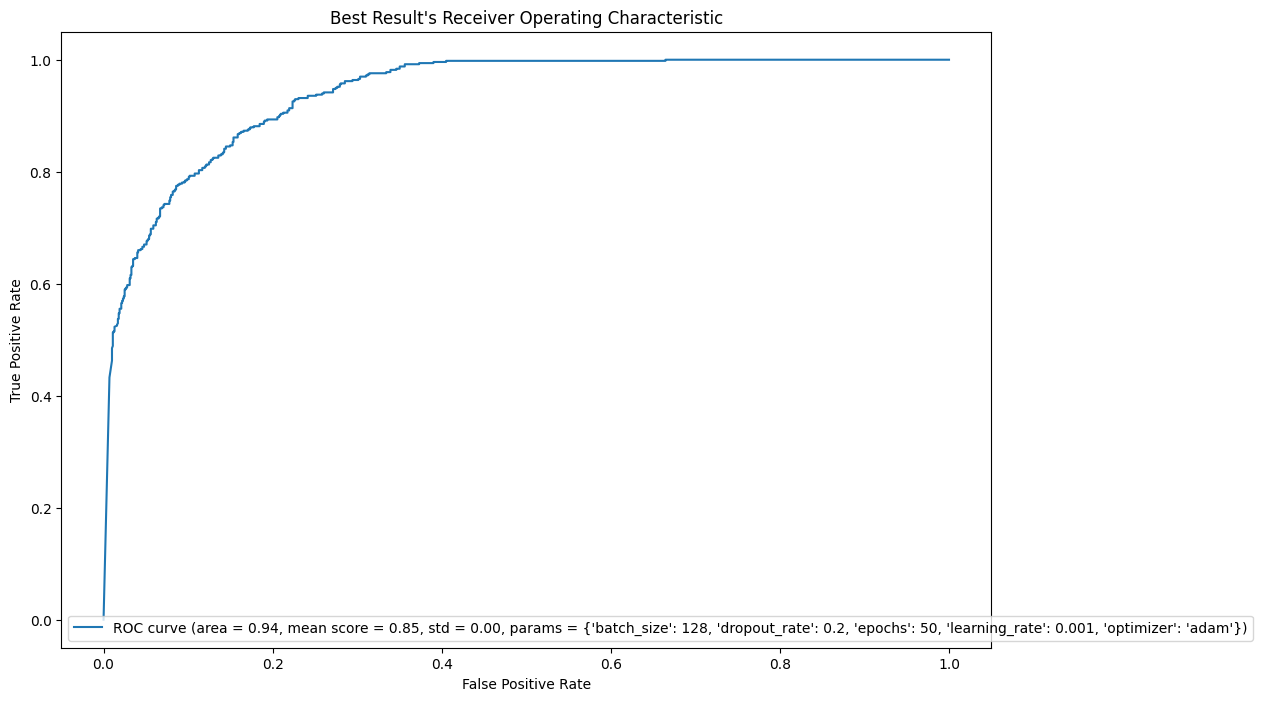

In [36]:
# Sort the results by AUC in descending order
sorted_results = sorted(prediction_results.items(), key=lambda x: x[1]['roc_auc'], reverse=True)

# Now, sorted_results is a list of tuples, where the first element of each tuple is the original key from prediction_results,
# and the second element is the corresponding dictionary with prediction results
# The list is sorted by the 'roc_auc' value in the dictionaries

# Example usage:
# Print the parameters of the best model (the one with the highest AUC)
print(sorted_results[0][1]['params'])

# Print the AUC of the best model
print(sorted_results[0][1]['roc_auc'])

# Plot the ROC curve of the best model
plt.figure(figsize=(12,8))
plt.plot(sorted_results[0][1]['fpr'], sorted_results[0][1]['tpr'],label=f'ROC curve (area = {roc_auc:.2f}, mean score = {mean_score:.2f}, std = {std_score:.2f}, params = {params})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Best Result's Receiver Operating Characteristic")
plt.legend(loc="best")
plt.show()


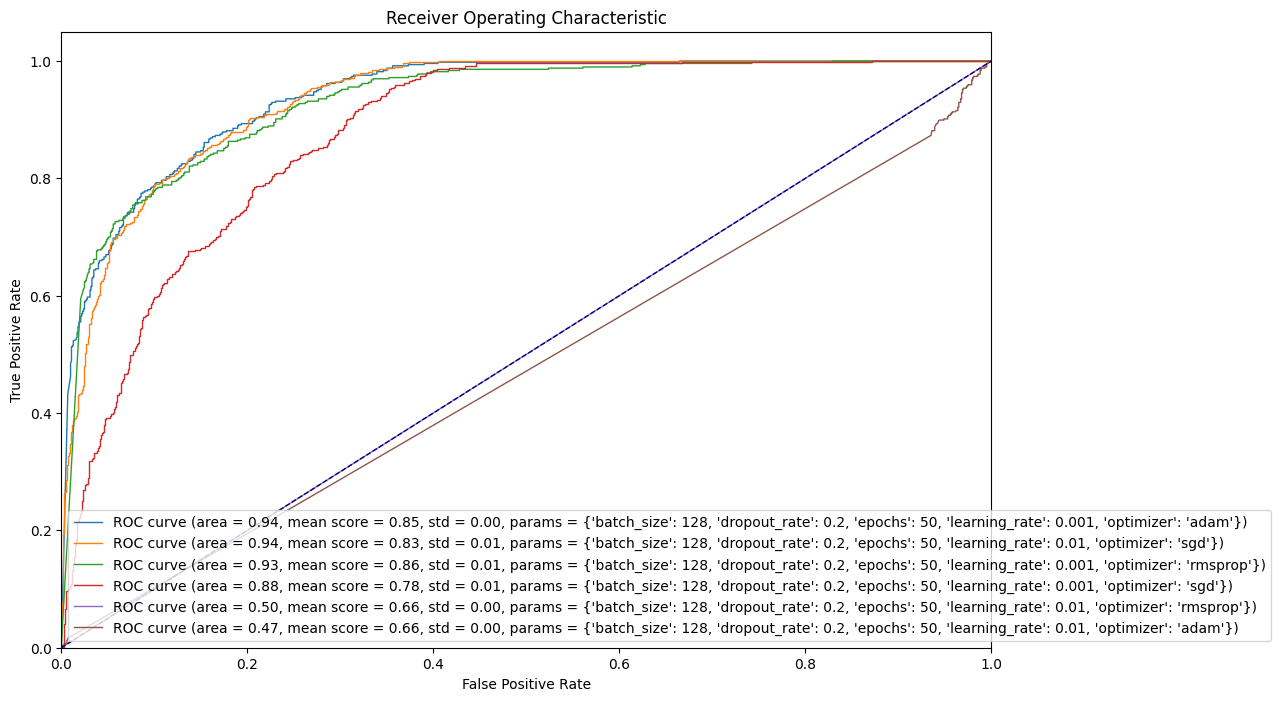

In [39]:
plt.figure(figsize=(12,8))

# Loop through the sorted results
for _, result in sorted_results:
    # Plot the ROC curve
    plt.plot(result['fpr'], result['tpr'], lw=1, label=f'ROC curve (area = {result["roc_auc"]:.2f}, mean score = {result["mean_score"]:.2f}, std = {result["std_score"]:.2f}, params = {result["params"]})')

# Add details to the plot
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="best")
plt.show()


In [ ]:
# Initialize a list to store the labels
y = []

# Loop through each sub-directory in the main directory
for dir in os.listdir(data_dir):
    for filename in os.listdir(os.path.join(data_dir, dir)):
        # Add the label to the list of labels
        y.append(dir)

# Convert the list to a NumPy array
y = np.array(y)

# Perform a train-test split
_, _, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
